# The CNN with ResNet backbone by transfer learning 

CHEST X-RAY IMAGES CLASSIFICATION WITH CNN

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

import os, shutil, pathlib


print("tensorflow version:", tf.__version__)
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)

tensorflow version: 2.10.0
numpy version: 1.23.4
pandas version: 1.5.1


## Paths of Data

In [2]:
DATA_PATH = "../data"
RAW_DATASET_NAME = "20210708_görüntüler"   # raw dataset folder name
SUB_FOLDERS_PATH = f"{DATA_PATH}/{RAW_DATASET_NAME}"  # sub class folders
MODELS_PATH = "../models"

SUB_FOLDERS_PATH

'../data/20210708_görüntüler'

In [3]:
os.listdir(DATA_PATH)

['20210708_görüntüler', 'images_1', 'manuel_differet_person']

In [4]:
labels = {"covid+ ac grafileri" : "covid",
         "infiltratif akciğer hastası grafileri" : "infiltiratif",
         "normal akciğer grafileri": "normal"}

labels

{'covid+ ac grafileri': 'covid',
 'infiltratif akciğer hastası grafileri': 'infiltiratif',
 'normal akciğer grafileri': 'normal'}

In [5]:
labels.values()

dict_values(['covid', 'infiltiratif', 'normal'])

# Prepare Data

In [6]:
def dataframe_for_folders(DATA_PATH, DATASET_NAME, labels):
    """create dataframe from data folders that every folder has one class data
    
    It prepares dataframe to put in  TF flow_from_dataframe function
    
    Args:
        DATA_PATH : parent folder relative path of DATASET_NAME. It contains all of data files.
        DATASET_NAME : dataset name which wanted to use - path from DATA_PATH to classes folders
        labels: a dict that contains folder names according to classes
        
    Returns:
        A pandas dataframe that has relative path to the dataset_name of data and labels
    """
    CLASS_FOLDERS_PATHS = os.listdir(f"{DATA_PATH}/{DATASET_NAME}")
    
    df = pd.DataFrame(columns=["path", "label"])  # empty dataframe
    
    for i in CLASS_FOLDERS_PATHS:
        # list files - images
        list_of_files = os.listdir(f"{DATASET_NAME}/{i}")
        
        for k, name in enumerate(list_of_files):
            list_of_files[k] = f"{i}/"+name       # add parent folder

        df = pd.concat([df, pd.DataFrame(list_of_files, columns=["path"])], ignore_index=True)
        df.fillna(labels[i], inplace=True)  # label column is NaN, so we put labels every iteration. because every folder has one class        
    
#     df.reset_index(inplace = True)  
    
    return df

In [7]:
df = dataframe_for_folders(DATA_PATH=DATA_PATH, DATASET_NAME=SUB_FOLDERS_PATH, labels=labels)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    336 non-null    object
 1   label   336 non-null    object
dtypes: object(2)
memory usage: 5.4+ KB


## Split Train and Test Data

In [8]:
from sklearn.model_selection import train_test_split

random_state=41
test_size = 0.2
df_train, df_test = train_test_split(df , test_size = test_size, random_state=random_state)

covid           128
normal          107
infiltiratif    101
Name: label, dtype: int64


Text(0.5, 1.0, 'Rates of Classes on All of Data')

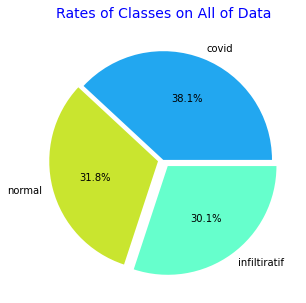

In [9]:
# Rates of Classes on All of Data
print(df.label.value_counts())

colors = ["#22a7f0","#c9e52f", "#66ffcc"]
# classes = ['covid', 'normal', "infiltiratif"]
classes = df.label.value_counts().index
explode = [0, 0.05, 0.07]

plt.figure(figsize = (5,5))
plt.pie(df.label.value_counts(), explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
plt.title("Rates of Classes on All of Data", color = 'blue',fontsize = 14)

covid           103
normal           86
infiltiratif     79
Name: label, dtype: int64


Text(0.5, 1.0, 'Rates of Classes on Train Data')

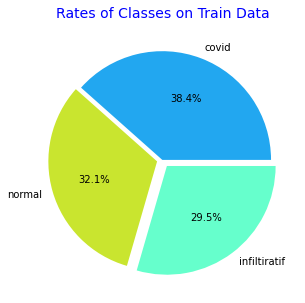

In [10]:
# Rates of Classes on Train Data
print(df_train.label.value_counts())

colors = ["#22a7f0","#c9e52f", "#66ffcc"]
# classes = ['covid', 'normal', "infiltiratif"]
classes = df_train.label.value_counts().index
explode = [0, 0.05, 0.07]

plt.figure(figsize = (5,5))
plt.pie(df_train.label.value_counts(), explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
plt.title("Rates of Classes on Train Data", color = 'blue',fontsize = 14)

covid           25
infiltiratif    22
normal          21
Name: label, dtype: int64


Text(0.5, 1.0, 'Rates of Classes on Test Data')

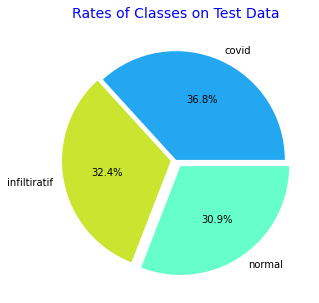

In [11]:
# Rates of Classes on Test Data
print(df_test.label.value_counts())

colors = ["#22a7f0","#c9e52f", "#66ffcc"]
# classes = ['covid', 'normal', "infiltiratif"]
classes = df_test.label.value_counts().index
explode = [0, 0.05, 0.07]

plt.figure(figsize = (5,5))
plt.pie(df_test.label.value_counts(), explode=explode, labels=classes, colors=colors, autopct='%1.1f%%')
plt.title("Rates of Classes on Test Data", color = 'blue',fontsize = 14)

# Preprocessing

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
SUB_FOLDERS_PATH

'../data/20210708_görüntüler'

In [14]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

# Resnet

In [16]:
width = 480
height = 480

input_size = (width, height)
input_shape = (width, height,3)

batch_size = 4
val_batch_size = 4
test_batch_size = 4

epochs = 50

train_datagen = ImageDataGenerator(validation_split=0.25)
test_datagen = ImageDataGenerator()



train_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=SUB_FOLDERS_PATH,
                                            x_col="path",
                                            y_col="label",
                                            subset="training",
                                            batch_size=batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=input_size)

validation_generator = train_datagen.flow_from_dataframe(dataframe=df_train,
                                            directory=SUB_FOLDERS_PATH,
                                            x_col="path",
                                            y_col="label",
                                            subset="validation",
                                            batch_size=val_batch_size,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="categorical",
                                            target_size=input_size)

test_generator = test_datagen.flow_from_dataframe(dataframe=df_test,
                                            directory=SUB_FOLDERS_PATH,
                                            x_col="path",
                                            y_col="label",
                                            batch_size=test_batch_size,
                                            seed=42,
                                            shuffle=False,
                                            class_mode="categorical",
                                            target_size=input_size)

resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=False,
                                                   weights='imagenet',
                                                   input_shape=input_shape,
                                                   pooling=None)

resnet50.trainable = False


def build_model(input_shape=input_shape):

    inputs = keras.Input(shape=input_shape)
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    x = resnet50(x)
    x = layers.Flatten()(x)
    
    x = layers.Dense(64, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

Found 201 validated image filenames belonging to 3 classes.
Found 67 validated image filenames belonging to 3 classes.
Found 68 validated image filenames belonging to 3 classes.


In [17]:
callbacks_list = [keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                patience=10,),
                  keras.callbacks.ModelCheckpoint(filepath="checkpoint_path.keras",
                                                  monitor="val_loss",
                                                  save_best_only=True,)]

In [18]:
model = build_model(input_shape)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 480, 480, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 480, 480, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 15, 15, 2048)      23587712  
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 64)                29491264  
                                                             

In [19]:
history = model.fit(train_generator, 
                    validation_data=validation_generator, 
                    epochs=epochs, 
                    callbacks=callbacks_list, 
                    batch_size=batch_size,
                    verbose=0)

# Training Graphs

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

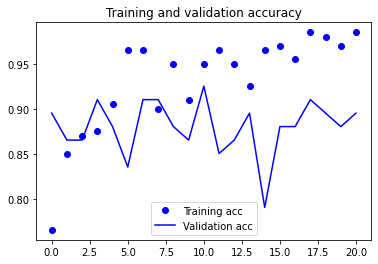

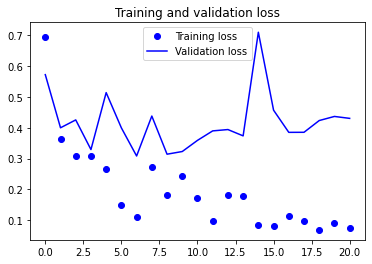

In [21]:
plot_history(history)

# Before Load Best Model

In [22]:
train_generator.reset()
train_loss, train_accuracy = model.evaluate(train_generator)
print("train_loss: ", train_loss)
print("train_accuracy", train_accuracy)

51/51 [==============================] - 5s 96ms/step - loss: 8.6089e-05 - accuracy: 1.0000
train_loss:  8.608915959484875e-05
train_accuracy 1.0


In [23]:
validation_generator.reset()
val_loss, val_accuracy = model.evaluate(validation_generator)
print("train_loss: ", val_loss)
print("train_accuracy", val_accuracy)

17/17 [==============================] - 2s 96ms/step - loss: 0.4306 - accuracy: 0.8955
train_loss:  0.4305694103240967
train_accuracy 0.89552241563797


In [24]:
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)
print("test_loss: ", test_loss)
print("test_accuracy", test_accuracy)

17/17 [==============================] - 2s 98ms/step - loss: 0.4152 - accuracy: 0.8529
test_loss:  0.415237158536911
test_accuracy 0.8529411554336548


# Reload the best model from Keras File
"We’ll reload the model from its saved file to evaluate it as it was before it started overfitting."

In [27]:
model = keras.models.load_model("checkpoint_path.keras")

# Best Model Results

In [28]:
train_generator.reset()
train_loss, train_accuracy = model.evaluate(train_generator)
print("train_loss: ", train_loss)
print("train_accuracy", train_accuracy)

51/51 [==============================] - 6s 97ms/step - loss: 0.0071 - accuracy: 0.9950
train_loss:  0.007082159165292978
train_accuracy 0.9950248599052429


In [29]:
validation_generator.reset()
val_loss, val_accuracy = model.evaluate(validation_generator)
print("train_loss: ", val_loss)
print("train_accuracy", val_accuracy)

17/17 [==============================] - 2s 97ms/step - loss: 0.3084 - accuracy: 0.9104
train_loss:  0.3084130883216858
train_accuracy 0.9104477763175964


In [30]:
test_generator.reset()
test_loss, test_accuracy = model.evaluate(test_generator)
print("test_loss: ", test_loss)
print("test_accuracy", test_accuracy)

17/17 [==============================] - 2s 98ms/step - loss: 0.3194 - accuracy: 0.8971
test_loss:  0.3193570375442505
test_accuracy 0.8970588445663452


# Save Model

In [26]:
MODELS_PATH = "../models"
MODEL_PATH = f"{MODELS_PATH}/resnet_model"

model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: ../models/resnet_model\assets


INFO:tensorflow:Assets written to: ../models/resnet_model\assets


# Accuracy on Test Set

In [31]:
test_generator.reset()
test_pred = model.predict(test_generator)

# Convert predictions classes to one hot vectors 
test_pred_classes = np.argmax(test_pred, axis = 1)

17/17 [==============================] - 2s 94ms/step


# Confusion Matrix

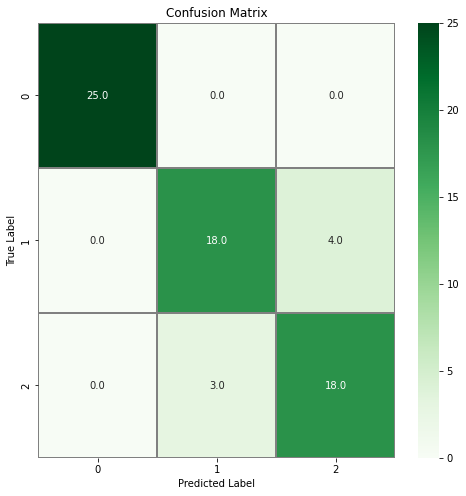

In [32]:
# confusion matrix
import seaborn as sns
 

# compute the confusion matrix
confusion_mtx = confusion_matrix(test_generator.classes, test_pred_classes) 

# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

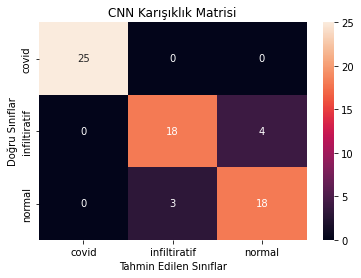

In [33]:
CATEGORIES = labels.values()

ax= plt.subplot()
sns.heatmap(confusion_mtx, annot=True, fmt="d", ) 
plt.xlabel("Tahmin Edilen Sınıflar")
plt.ylabel("Doğru Sınıflar")
plt.title("CNN Karışıklık Matrisi")
ax.xaxis.set_ticklabels(CATEGORIES); ax.yaxis.set_ticklabels(CATEGORIES);
plt.show()

In [34]:
#Confution Matrix and Classification Report
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, test_pred_classes))
print('Classification Report')
print(classification_report(test_generator.classes, test_pred_classes, target_names=CATEGORIES))

Confusion Matrix
[[25  0  0]
 [ 0 18  4]
 [ 0  3 18]]
Classification Report
              precision    recall  f1-score   support

       covid       1.00      1.00      1.00        25
infiltiratif       0.86      0.82      0.84        22
      normal       0.82      0.86      0.84        21

    accuracy                           0.90        68
   macro avg       0.89      0.89      0.89        68
weighted avg       0.90      0.90      0.90        68

